Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [5]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [6]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [8]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [10]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [11]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [12]:
transforms2=Compose([],p=1)

In [13]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [14]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [15]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [16]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [17]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [18]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

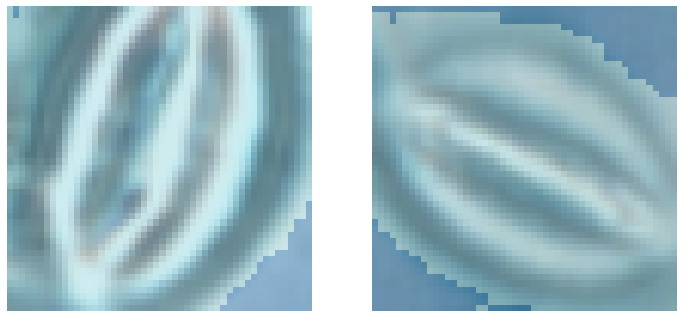

In [19]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [ ]:
from architectures import OCNet
model = OCNet(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [21]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/OCNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

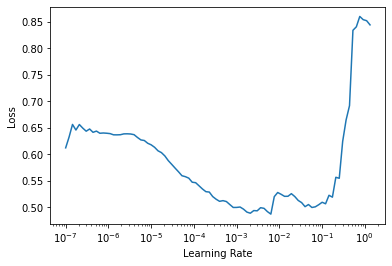

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.242287,0.274683,0.928773,0.867019,10:50
1,0.220143,0.287861,0.929639,0.868529,10:57
2,0.236438,0.265348,0.936411,0.880426,10:57
3,0.198403,0.297933,0.937395,0.882167,10:57
4,0.213787,0.231719,0.941447,0.889372,10:56
5,0.193387,0.204846,0.946576,0.898570,10:55
6,0.206230,0.200236,0.949540,0.903928,10:57
7,0.205167,0.184512,0.951850,0.908124,10:52
8,0.184771,0.183516,0.952635,0.909554,11:00
9,0.174507,0.205252,0.946413,0.898277,11:01


Better model found at epoch 0 with valid_loss value: 0.27468299865722656.


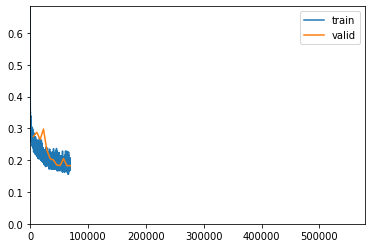

Better model found at epoch 2 with valid_loss value: 0.26534807682037354.
Better model found at epoch 4 with valid_loss value: 0.23171858489513397.
Better model found at epoch 5 with valid_loss value: 0.2048458307981491.
Better model found at epoch 6 with valid_loss value: 0.20023606717586517.
Better model found at epoch 7 with valid_loss value: 0.18451225757598877.
Better model found at epoch 8 with valid_loss value: 0.1835162490606308.
Better model found at epoch 10 with valid_loss value: 0.18263567984104156.
No improvement since epoch 10: early stopping


In [ ]:
name = "model_OCNet_resnet50_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18263567984104156,0.9528912705185401,0.9100213222273704]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

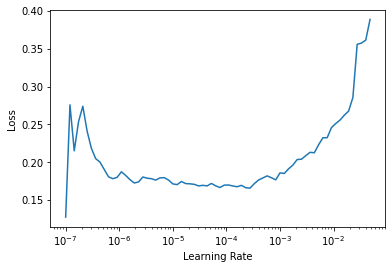

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.167896,0.179277,0.954383,0.912746,10:58
1,0.168158,0.175764,0.954890,0.913675,10:57
2,0.164930,0.177798,0.955220,0.914278,11:05
3,0.157930,0.175277,0.955121,0.914096,11:04
4,0.163701,0.173684,0.954835,0.913574,11:01
5,0.171166,0.178118,0.954431,0.912834,11:06
6,0.165754,0.178381,0.954688,0.913304,11:04


Better model found at epoch 0 with valid_loss value: 0.17927658557891846.


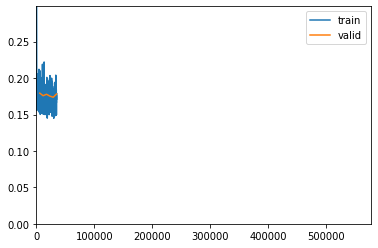

Better model found at epoch 1 with valid_loss value: 0.17576384544372559.
Better model found at epoch 3 with valid_loss value: 0.17527729272842407.
Better model found at epoch 4 with valid_loss value: 0.17368446290493011.
No improvement since epoch 4: early stopping


In [ ]:
name = "model_OCNet_resnet50_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17368446290493011,0.9548352052519312,0.9135738307011088]



---


Definición del modelo.

In [22]:
del model, learn
model = OCNet(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [23]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/OCNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

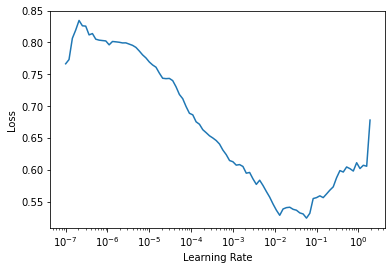

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.262830,0.304695,0.924728,0.859994,06:47
1,0.241840,0.273469,0.930866,0.870673,06:46
2,0.222901,0.251442,0.936743,0.881012,06:47
3,0.217861,0.247370,0.940046,0.886875,06:45
4,0.198344,0.218560,0.946030,0.897588,06:46
5,0.205030,0.192202,0.951107,0.906772,06:47
6,0.204750,0.201419,0.949309,0.903510,06:47
7,0.192759,0.190770,0.951099,0.906759,06:45
8,0.200693,0.180806,0.953396,0.910943,06:45
9,0.188130,0.182666,0.953256,0.910687,06:46


Better model found at epoch 0 with valid_loss value: 0.3046945035457611.


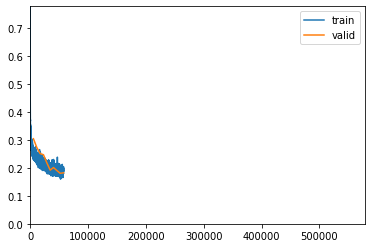

Better model found at epoch 1 with valid_loss value: 0.27346912026405334.
Better model found at epoch 2 with valid_loss value: 0.2514418661594391.
Better model found at epoch 3 with valid_loss value: 0.24736951291561127.
Better model found at epoch 4 with valid_loss value: 0.21855995059013367.
Better model found at epoch 5 with valid_loss value: 0.1922023892402649.
Better model found at epoch 7 with valid_loss value: 0.19076994061470032.
Better model found at epoch 8 with valid_loss value: 0.18080569803714752.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_OCNet_resnet50_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18080569803714752,0.9533960834527931,0.9109425909642012]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

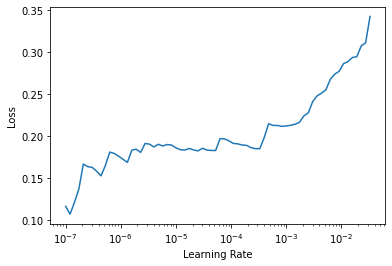

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.174754,0.183064,0.953172,0.910534,06:48
1,0.172423,0.179157,0.953933,0.911924,06:46
2,0.181733,0.174903,0.955334,0.914487,06:49
3,0.177853,0.182461,0.954013,0.912070,06:49
4,0.162063,0.188444,0.952578,0.909449,06:47


Better model found at epoch 0 with valid_loss value: 0.1830638349056244.


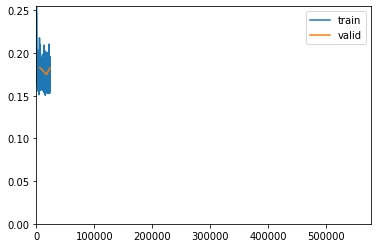

Better model found at epoch 1 with valid_loss value: 0.1791568249464035.
Better model found at epoch 2 with valid_loss value: 0.17490316927433014.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_OCNet_resnet50_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17490316927433014,0.9553337040043426,0.914486958817626]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = OCNet(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/OCNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

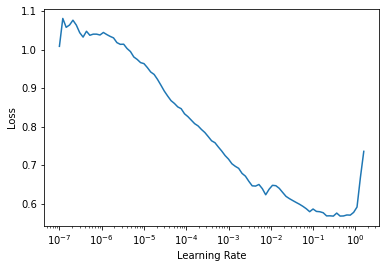

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.251270,0.343009,0.924889,0.860273,06:50
1,0.243463,0.263801,0.931106,0.871093,06:49
2,0.231966,0.242088,0.937187,0.881798,06:51
3,0.204669,0.225186,0.941722,0.889862,06:50
4,0.197016,0.227626,0.943237,0.892573,06:49
5,0.192549,0.200494,0.949198,0.903308,06:49
6,0.190542,0.195700,0.950234,0.905186,06:50
7,0.194177,0.201134,0.950373,0.905439,06:51
8,0.178562,0.180408,0.952777,0.909813,06:48
9,0.171805,0.193189,0.950201,0.905127,06:49


Better model found at epoch 0 with valid_loss value: 0.3430088460445404.


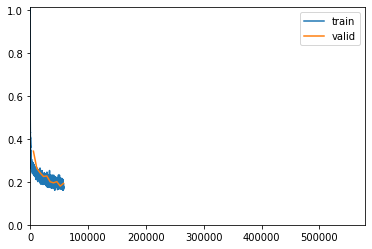

Better model found at epoch 1 with valid_loss value: 0.26380136609077454.
Better model found at epoch 2 with valid_loss value: 0.2420882284641266.
Better model found at epoch 3 with valid_loss value: 0.22518640756607056.
Better model found at epoch 5 with valid_loss value: 0.20049390196800232.
Better model found at epoch 6 with valid_loss value: 0.19570040702819824.
Better model found at epoch 8 with valid_loss value: 0.18040768802165985.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_OCNet_resnet50_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17354260385036469,0.9548603755253223,0.9136199156215775]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

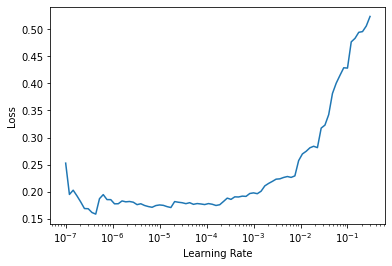

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.179227,0.171733,0.955927,0.915575,06:22
1,0.166343,0.174367,0.955438,0.914679,06:23
2,0.173086,0.175940,0.955598,0.914972,06:25


Better model found at epoch 0 with valid_loss value: 0.17173345386981964.


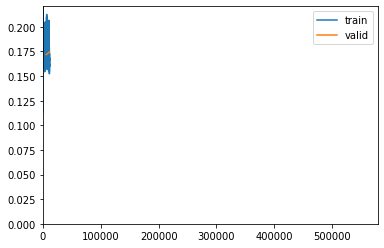

No improvement since epoch 0: early stopping


In [ ]:
name = "model_OCNet_resnet50_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17173345386981964,0.9559269643156628,0.915574803336532]



---


Definición del modelo.

In [ ]:
del model, learn
model = OCNet(backbone_name="resnet50", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/OCNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

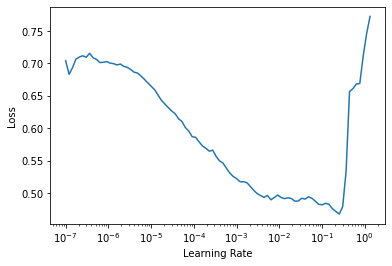

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.249721,0.350130,0.926897,0.863755,06:26
1,0.217211,0.264400,0.932087,0.872811,06:24
2,0.218419,0.244612,0.936216,0.880081,06:23
3,0.212008,0.227370,0.941499,0.889464,06:27
4,0.177557,0.225518,0.945546,0.896717,06:26
5,0.183838,0.248947,0.942106,0.890549,06:25
6,0.219701,0.190356,0.951519,0.907521,06:28
7,0.196269,0.183596,0.953493,0.911120,06:23
8,0.205635,0.183823,0.953534,0.911195,06:18
9,0.180628,0.185474,0.952110,0.908597,06:25


Better model found at epoch 0 with valid_loss value: 0.35012951493263245.


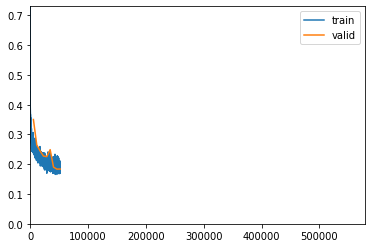

Better model found at epoch 1 with valid_loss value: 0.2643997073173523.
Better model found at epoch 2 with valid_loss value: 0.24461176991462708.
Better model found at epoch 3 with valid_loss value: 0.22736957669258118.
Better model found at epoch 4 with valid_loss value: 0.22551776468753815.
Better model found at epoch 6 with valid_loss value: 0.19035567343235016.
Better model found at epoch 7 with valid_loss value: 0.18359582126140594.
No improvement since epoch 7: early stopping


In [ ]:
name = "model_OCNet_resnet50_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18359582126140594,0.9534933971057322,0.9111202876969015]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

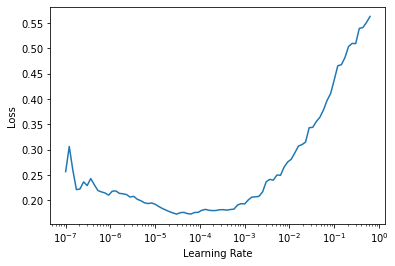

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.182336,0.181778,0.954227,0.912462,06:25
1,0.182860,0.177837,0.954915,0.913720,06:24
2,0.164782,0.191935,0.953309,0.910783,06:27
3,0.179959,0.185906,0.953221,0.910623,06:27


Better model found at epoch 0 with valid_loss value: 0.18177840113639832.


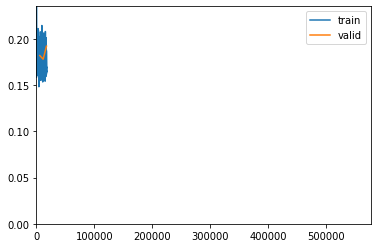

Better model found at epoch 1 with valid_loss value: 0.17783688008785248.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_OCNet_resnet50_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_OCNet_resnet50_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17783688008785248,0.9549150184447371,0.9137199704311724]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.168031707406044,0.9570092607990687,0.9175625677484579]

Comparación de resultado buscado contra resultado obtenido.

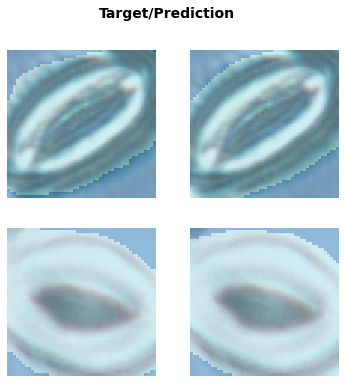

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16234354674816132,0.9579603065503195,0.9193126831656331]

Comparación de resultado buscado contra resultado obtenido.

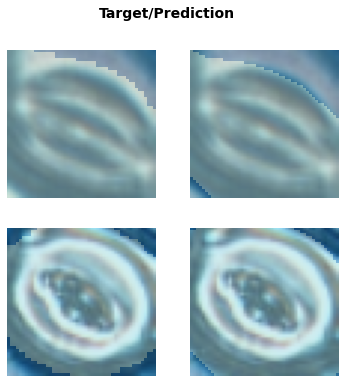

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16851681470870972,0.9564798414707572,0.9165897119024877]

Comparación de resultado buscado contra resultado obtenido.

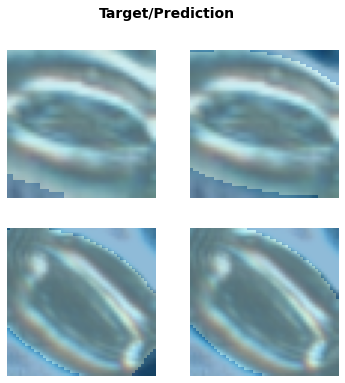

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16077920794487,0.9586843974564079,0.9206472995455524]

Comparación de resultado buscado contra resultado obtenido.

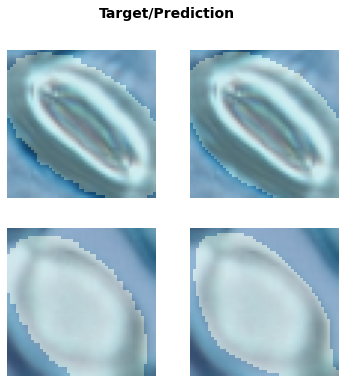

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16115908324718475,0.9585781769043615,0.9204514017720282]

Comparación de resultado buscado contra resultado obtenido.

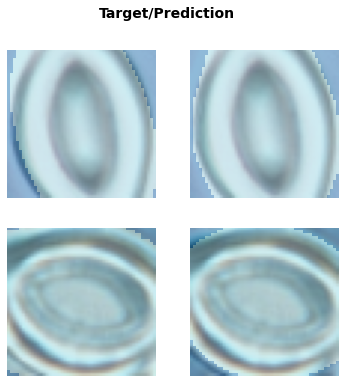

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16063497960567474,0.9587185105802364,0.9207102213201408]

Comparación de resultado buscado contra resultado obtenido.

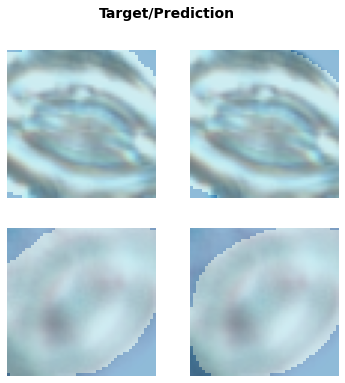

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16872139275074005,0.9570247307304921,0.9175910099966081]

Comparación de resultado buscado contra resultado obtenido.

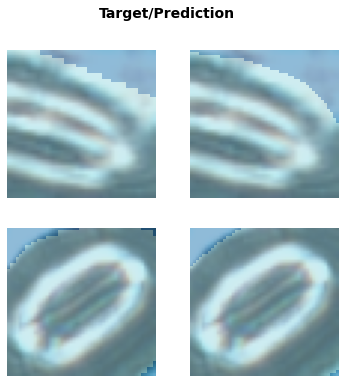

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_OCNet_resnet50_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16271518170833588,0.9584434550060109,0.9202029977273506]

Comparación de resultado buscado contra resultado obtenido.

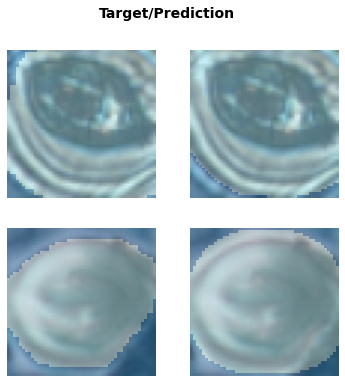

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [24]:
learn.load("model_OCNet_resnet50_da_wd1_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16077920794487,0.9586843974564079,0.9206472995455524]

In [25]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [26]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/OCNet/model_OCNet_resnet50.pkl")